In [1]:
import torch
from torch import nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from torch.optim import Adam
import random
import copy

In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)) # map values from [0, 1] -> [-1, 1] for tanh()
])

In [3]:
train = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test  = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_dataset = torch.utils.data.ConcatDataset([train, test])

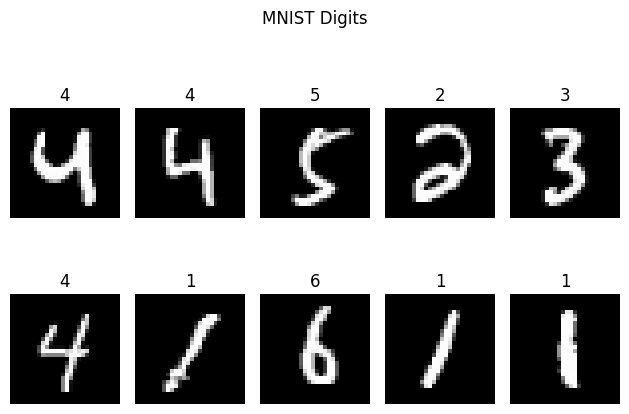

In [4]:
fig, axes = plt.subplots(2, 5)
axes = axes.flatten()

for i in range(10):
  idx = random.randrange(0, len(train_dataset))
  image, label = train_dataset[idx]
  axes[i].imshow(image.squeeze(), cmap='gray')
  axes[i].set_title(label)
  axes[i].axis('off')

fig.suptitle("MNIST Digits")
fig.tight_layout()
plt.show()

The Model

In [5]:
class Encoder(nn.Module):
  def __init__(self, input_dim, latent_dim):
    super().__init__()

    self.conv_stack = nn.Sequential(
        nn.Conv2d(in_channels=1, out_channels=16, kernel_size=4, stride=2, padding=1), nn.ReLU(),
        nn.Conv2d(in_channels=16, out_channels=32, kernel_size=4, stride=2, padding=1), nn.ReLU(),
        nn.Flatten()
    )

    self.fc_mu = nn.Linear(in_features=32*7*7, out_features=latent_dim)
    self.fc_logvar = nn.Linear(in_features=32*7*7, out_features=latent_dim)

  def forward(self, x):
    x = self.conv_stack(x)
    mu = self.fc_mu(x)
    logvar = self.fc_logvar(x)
    return mu, logvar

In [6]:
class Decoder(nn.Module):
  def __init__(self, input_dim, latent_dim):
    super().__init__()

    self.linear = nn.Linear(in_features=latent_dim, out_features=32*7*7)

    self.deconv_stack = nn.Sequential(
        nn.ConvTranspose2d(in_channels=32, out_channels=16, kernel_size=4, stride=2, padding=1), nn.ReLU(),
        nn.ConvTranspose2d(in_channels=16, out_channels=input_dim, kernel_size=4, stride=2, padding=1), nn.Tanh()
    )

  def forward(self, x):
    x = self.linear(x)
    x = x.reshape(-1, 32, 7, 7)
    x = self.deconv_stack(x)
    return x

In [7]:
class MnistVAE(nn.Module):
  def __init__(self, input_dim, latent_dim):
    super().__init__()
    self.encoder = Encoder(input_dim=input_dim, latent_dim=latent_dim)
    self.decoder = Decoder(input_dim=input_dim, latent_dim=latent_dim)

  def reparametrize(self, mu, logvar):
    eps = torch.randn_like(mu)
    stdev = torch.exp(logvar/2)
    z = mu + stdev*eps
    return z

  def forward(self, x):
    x_mu, x_logvar = self.encoder(x)
    x = self.reparametrize(x_mu, x_logvar.clamp(-20, 20))
    x = self.decoder(x)
    return x, x_mu, x_logvar

Training

In [8]:
epochs = 200
batch_size = 128
lr = 5e-3
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = MnistVAE(input_dim=1, latent_dim=6).to(device)
optimizer = Adam(model.parameters(), lr=lr)

In [9]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [10]:
def calculate_loss(images, recon, mu, logvar):
  recon_loss = torch.sum((images - recon).pow(2))
  kld = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
  return recon_loss + kld

In [11]:
best_loss = float('inf')
for epoch_idx in range(epochs):
  model.train()

  epoch_loss = 0
  for images, _ in train_loader:
    images = images.to(device)
    recon, mu, logvar = model(images)
    loss = calculate_loss(images, recon, mu, logvar)
    epoch_loss += loss.item()
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  epoch_loss /= len(train_loader)
  print(f"[{epoch_idx+1}/{epochs}]: {epoch_loss:.4f}")

  if epoch_loss < best_loss:
    best_loss = epoch_loss
    best_model_state = copy.deepcopy(model.state_dict())

torch.save(best_model_state, "best_model.pt")

torch.save(model.state_dict(), "last_model.pt")

print(f"Training complete. Best loss: {best_loss: .4f}")

[1/200]: 18820.1732
[2/200]: 13396.0798
[3/200]: 12865.1958
[4/200]: 12596.3695
[5/200]: 12388.2734
[6/200]: 12265.6647
[7/200]: 12166.3829
[8/200]: 12122.5189
[9/200]: 12051.2957
[10/200]: 12003.0779
[11/200]: 11935.7087
[12/200]: 11886.6502
[13/200]: 11894.0164
[14/200]: 11911.4160
[15/200]: 11808.4961
[16/200]: 11782.9124
[17/200]: 11835.7918
[18/200]: 11815.4388
[19/200]: 11785.6668
[20/200]: 11738.5102
[21/200]: 11722.5351
[22/200]: 11694.2636
[23/200]: 11711.2275
[24/200]: 11710.6454
[25/200]: 11653.4737
[26/200]: 11654.0714
[27/200]: 11643.1863
[28/200]: 11673.3201
[29/200]: 11651.2520
[30/200]: 11637.9467
[31/200]: 11632.6960
[32/200]: 11598.0399
[33/200]: 11605.9651
[34/200]: 11619.7758
[35/200]: 11620.1116
[36/200]: 11609.6084
[37/200]: 11584.2656
[38/200]: 11581.6567
[39/200]: 11673.1606
[40/200]: 11623.9607
[41/200]: 11577.0059
[42/200]: 11556.1073
[43/200]: 11573.2122
[44/200]: 11534.7029
[45/200]: 11568.0852
[46/200]: 11573.2122
[47/200]: 11553.2117
[48/200]: 11558.9861
[

In [12]:
# input = torch.randn([1, 28, 28])
# conv_stack = nn.Sequential(
#         nn.Conv2d(in_channels=1, out_channels=16, kernel_size=4, stride=2, padding=1), nn.ReLU(),
#         nn.Conv2d(in_channels=16, out_channels=32, kernel_size=4, stride=2, padding=1), nn.ReLU(),
#         nn.Flatten(start_dim=0)
#       )
# lin = nn.Linear(in_features=32*7*7, out_features=6)
# output = lin(conv_stack(input))

# output.shape